# KAN Symbol Error Rate (SER) Analysis & Laboratory

This notebook performs a comprehensive analysis of Kolmogorov-Arnold Networks (KAN) for **4CSK** and **8CSK** modulation. 

**Key Features:**
- **Robust Data Logging**: All experiment results are saved to `.csv` files for later analysis.
- **Detailed Metrics**: Confusion Matrices and Classification Reports.
- **Scientific Plotting**: Figures formatted for IEEE publication standards (saved as PNG and EPS).

## Datasets
- `data_4csk.csv`
- `data_8csk.csv`

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
from tqdm import tqdm
import itertools

# Import KAN implementation
try:
    from torch_relu_kan import ReLUKAN
except ImportError:
    print("Error: torch_relu_kan.py not found. Please ensure it stands in the same directory.")

# Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Create Output Directory
OUTPUT_DIR = "results"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Results will be saved to: {OUTPUT_DIR}/")

Using device: cuda
Results will be saved to: results/


## 1. IEEE Plotting Style Configuration

In [2]:
# Configure Matplotlib for IEEE Scientific Style
# Ensure Times New Roman or similar serif font is used
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 18,
    'axes.labelsize': 18,
    'axes.titlesize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.titlesize': 18,
    'figure.dpi': 300,
    'text.usetex': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'axes.prop_cycle': plt.cycler(color=['#0072BD', '#D95319', '#EDB120', '#7E2F8E', '#77AC30', '#4DBEEE', '#A2142F']) # MATLAB-like high contrast colors
})
print("IEEE Plotting Style Applied.")

IEEE Plotting Style Applied.


## 2. Utilities: Data Loading, Training, & Evaluation

In [3]:
def load_data(filepath, feature_cols, target_col='Symbol', train_size=64, test_size=None, normalize=True, return_numpy=False):
    """Loads, splits, and optionally scales data. Default train_size is 64 samples."""
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"File {filepath} not found!")
        return None, None, None, None, None

    X = df[feature_cols].values
    y = df[target_col].values
    
    if test_size is not None:
        # First split train vs rest
        X_train, X_rest, y_train, y_rest = train_test_split(
            X, y, train_size=train_size, random_state=SEED, stratify=y
        )
        # Then split test from rest if test_size is specified and adequate
        if len(X_rest) > test_size:
             # We want exactly test_size for testing.
             X_test, _, y_test, _ = train_test_split(X_rest, y_rest, train_size=test_size, random_state=SEED, stratify=y_rest)
        else:
             if len(X_rest) < test_size:
                 print(f"Warning: Not enough samples for requested test_size {test_size}. Using all {len(X_rest)} remaining.")
             X_test, y_test = X_rest, y_rest
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=train_size, random_state=SEED, stratify=y
        )
    
    # Scale
    if normalize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    if return_numpy:
        return X_train, X_test, y_train, y_test, len(np.unique(y))

    # Convert to tensors
    X_train = torch.FloatTensor(X_train).unsqueeze(-1).to(device)
    y_train = torch.LongTensor(y_train).to(device)
    X_test = torch.FloatTensor(X_test).unsqueeze(-1).to(device)
    y_test = torch.LongTensor(y_test).to(device)
    
    return X_train, X_test, y_train, y_test, len(np.unique(y))

In [4]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=200, lr=0.01, weight_decay=1e-4, verbose=False):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    history = {'train_loss': [], 'test_ser': [], 'test_acc': []}
    best_ser = 1.0
    best_model_state = None

    iterator = range(epochs)
    if verbose:
        iterator = tqdm(iterator, desc="Training")

    for epoch in iterator:
        model.train()
        optimizer.zero_grad()
        output = model(X_train).squeeze(-1)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        
        history['train_loss'].append(loss.item())

        # Evaluation
        model.eval()
        with torch.no_grad():
            test_out = model(X_test).squeeze(-1)
            test_loss = criterion(test_out, y_test)
            _, preds = torch.max(test_out, 1)
            accuracy = (preds == y_test).float().mean().item()
            ser = 1.0 - accuracy
            
            history['test_ser'].append(ser)
            history['test_acc'].append(accuracy)
            
            if ser < best_ser:
                best_ser = ser
                best_model_state = copy.deepcopy(model.state_dict())
        
        scheduler.step(test_loss)
        
        if verbose and (epoch % 50 == 0):
            iterator.set_postfix(loss=loss.item(), ser=ser)

    return best_ser, history, best_model_state

In [5]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", filename=None):
    cm = confusion_matrix(y_true, y_pred)
    # Creating a nicely formatted IEEE style figure
    plt.figure(figsize=(5, 4)) # Compact figure for column width
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')
    plt.xlabel('Predicted Symbol')
    plt.ylabel('True Symbol')
    # plt.title(title) # Title removed per user request
    plt.grid(False) # Remove grid for CM
    plt.tight_layout()
    
    if filename:
        # Save as PNG
        path_png = os.path.join(OUTPUT_DIR, filename)
        plt.savefig(path_png, dpi=300, bbox_inches='tight')
        
        # Save as EPS
        path_eps = path_png.replace('.png', '.pdf')
        plt.savefig(path_eps, format='pdf', dpi=300, bbox_inches='tight')
        
        print(f"Saved CM plot to {path_png} and {path_eps}")
    plt.show()

## 3. Experiment 1: Feature Selection

--- Experiment 1: Combined Feature & Hyperparameter Search (Mean Selection) ---
Searching data_4csk.csv...
Best for data_4csk.csv: $T_{wCE}$ | Mean SER 0.1094 (+/- 0.0000)
Searching data_8csk.csv...
Best for data_8csk.csv: $T$ | Mean SER 0.1250 (+/- 0.0128)


<Figure size 3000x1800 with 0 Axes>

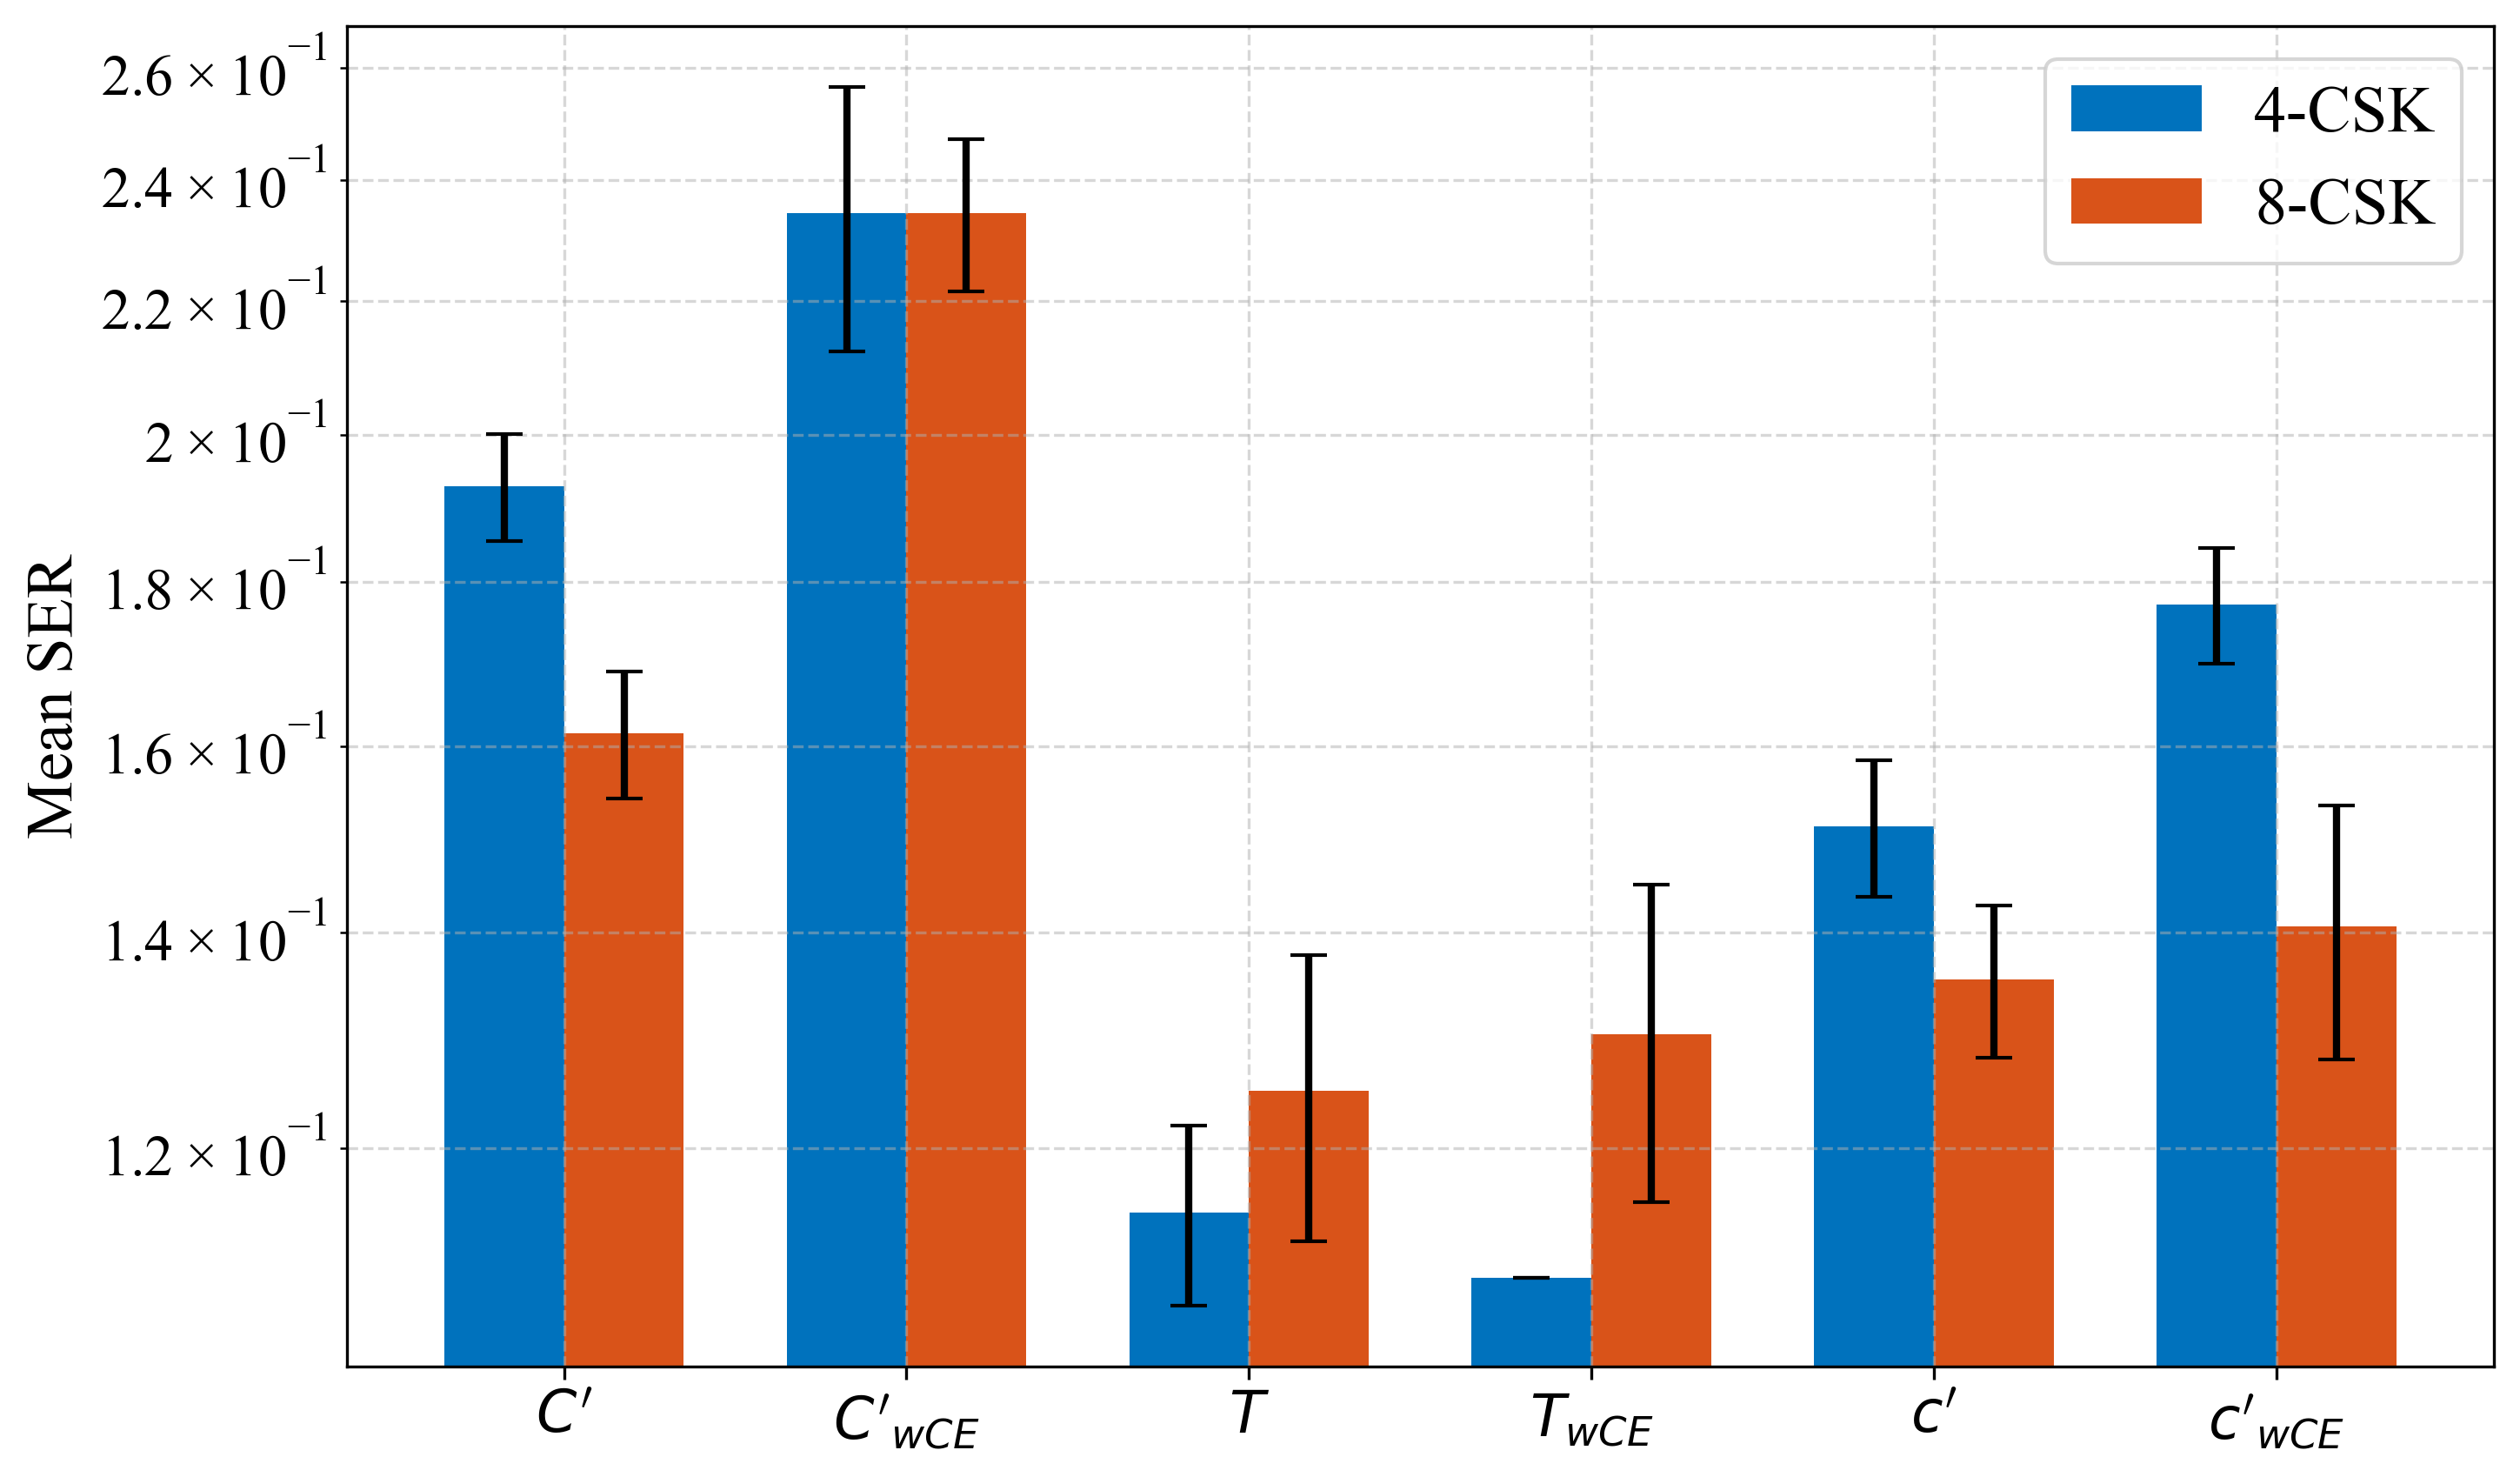

In [6]:
# Global dictionaries to store best configurations
best_features_global = {}
best_params_global = {}

feature_candidates = {
    r'$T_{wCE}$': ['Vr', 'Vg', 'Vb'],
    r'$T$': ['R', 'G', 'B'],
    r"$C'$": ['X', 'Y', 'Z'],
    r"$c'$": ['x', 'y'],
    r"$C'_{wCE}$": ['X_ne', 'Y_ne', 'Z_ne'],
    r"$c'_{wCE}$": ['x_ne', 'y_ne']
}   

# Hyperparameter Grid
param_grid = {
    'grid': [3],
    'k': [4],
    'lr': [ 1e-3],
    'weight_decay': [1e-3],
    'hidden_layers': [[10], [25], [100], [10,10], [10,10,10]]
}

keys, values = zip(*param_grid.items())
permutations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Storage for aggregation
results_comb = {'Dataset': [], 'Feature_Set': [], 'Params': [], 'Layers': [], 'Mean_SER': [], 'Std_SER': []}

print("--- Experiment 1: Combined Feature & Hyperparameter Search (Mean Selection) ---")
N_REPEATS = 3  # Repeats for statistical validity
SEARCH_EPOCHS =  50 # Reduced epochs for faster search

for filename in ['data_4csk.csv', 'data_8csk.csv']:
    print(f"Searching {filename}...")
    best_mean_ser_file = 1.0
    best_config_file = {}

    norm = True

    for feat_name, cols in feature_candidates.items():
        X_train, X_test, y_train, y_test, num_classes = load_data(
            filename, cols, train_size=64, test_size=64, normalize=norm
        )

        for params in permutations:
            sers = []
            layers = [len(cols)] + params['hidden_layers'] + [num_classes]
            
            # Repeat training to get mean/std
            for _ in range(N_REPEATS):
                model = ReLUKAN(layers, grid=params['grid'], k=params['k']).to(device)
                best_ser_run, _, _ = train_model(model, X_train, y_train, X_test, y_test, 
                                             epochs=SEARCH_EPOCHS, lr=params['lr'], weight_decay=params['weight_decay'], verbose=False)
                sers.append(best_ser_run)
            
            mean_ser = np.mean(sers)
            std_ser = np.std(sers)

            results_comb['Dataset'].append(filename)
            results_comb['Feature_Set'].append(feat_name)
            results_comb['Params'].append(str(params))
            results_comb['Layers'].append(str(params['hidden_layers']))
            results_comb['Mean_SER'].append(mean_ser)
            results_comb['Std_SER'].append(std_ser)

            if mean_ser < best_mean_ser_file:
                best_mean_ser_file = mean_ser
                best_config_file = {'cols': cols, 'name': feat_name, 'params': params, 'norm': norm, 'mean': mean_ser, 'std': std_ser}

    best_features_global[filename] = {'cols': best_config_file['cols'], 'norm': best_config_file['norm']}
    best_params_global[filename] = best_config_file['params']

    print(f"Best for {filename}: {best_config_file['name']} | Mean SER {best_config_file['mean']:.4f} (+/- {best_config_file['std']:.4f})")

df_res = pd.DataFrame(results_comb)
df_res['Dataset'] = df_res['Dataset'].replace({'data_4csk.csv': '4-CSK', 'data_8csk.csv': '8-CSK'})
df_res.to_csv(os.path.join(OUTPUT_DIR, 'results_combined_search.csv'), index=False)
# Plotting: Bar plot of the BEST configuration for each Feature Set
# Get best metrics per (Dataset, Feature_Set)
best_indices = df_res.groupby(['Dataset', 'Feature_Set'])['Mean_SER'].idxmin()
df_best_per_feat = df_res.loc[best_indices].copy()

plt.figure(figsize=(10, 6))
sns.barplot(x='Feature_Set', y='Mean_SER', hue='Dataset', data=df_best_per_feat, capsize=.1)
plt.clf() # Clear previous
datasets = df_best_per_feat['Dataset'].unique()
features = df_best_per_feat['Feature_Set'].unique()
x = np.arange(len(features))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
for i, ds in enumerate(datasets):
    subset = df_best_per_feat[df_best_per_feat['Dataset'] == ds]
    # Ensure order matches 'features'
    subset = subset.set_index('Feature_Set').reindex(features).reset_index()
    
    ax.bar(x + i*width, subset['Mean_SER'], width, label=ds, yerr=subset['Std_SER'], capsize=5)

ax.set_ylabel('Mean SER')
ax.set_xticks(x + width / 2 if len(datasets) > 1 else x)
ax.set_xticklabels(features)
ax.legend()
ax.set_yscale('log')
ax.grid(True, linestyle='--', which='both', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'plot_combined_search.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_DIR, 'plot_combined_search.pdf'), format='pdf', dpi=300)


## 4. Experiment 2: Hyperparameter Tuning (Grid Search)

In [7]:
print("\n--- Experiment 2: Redundant (Merged into Exp 1) ---")
# This experiment is skipped as Feature & Hyperparameter search are now combined in Experiment 1.



--- Experiment 2: Redundant (Merged into Exp 1) ---


## 5. Experiment 3: Sample Efficiency

In [ ]:
print("\n--- Experiment 3: Sample Efficiency ---")
train_sizes_list = [8, 16, 32, 64, 128, 256, 512, 1024]
results_eff = {'Dataset': [], 'Train_Size': [], 'SER': []}


# 10 realizações, 1024
# -40db -> -80db

for filename in ['data_4csk.csv', 'data_8csk.csv']:
    print(f"Analyzing {filename}...")
    # Retrieve settings
    if 'best_features_global' in locals() and filename in best_features_global:
        feat_cols = best_features_global[filename]['cols']
        do_norm = best_features_global[filename]['norm']
    else:
        feat_cols = ['Vr', 'Vg', 'Vb']
        do_norm = True
            
    if 'best_params_global' in locals() and filename in best_params_global:
        params = best_params_global[filename]
    else:
        params = {'grid': 5, 'k': 3, 'lr': 0.01, 'weight_decay': 1e-4}
    for tr_size in train_sizes_list:
        if tr_size > 700: # Check to ensure we don't exceed dataset limits significantly if small
             continue
             
        X_train, X_test, y_train, y_test, num_classes = load_data(
            filename, 
            feat_cols,
            train_size=tr_size,
            normalize=do_norm
        )
        
        # Guard against empty test sets if dataset is small
        if X_test is None or len(X_test) == 0:
             continue

        hidden = params.get('hidden_layers', [8])
        layers = [len(feat_cols)] + hidden + [num_classes]
        model = ReLUKAN(layers, grid=params['grid'], k=params['k']).to(device)
        best_ser, _, _ = train_model(model, X_train, y_train, X_test, y_test, epochs=150, lr=params['lr'], weight_decay=params['weight_decay'], verbose=False)
        
        results_eff['Dataset'].append(filename)
        results_eff['Train_Size'].append(tr_size)
        results_eff['SER'].append(best_ser)
        print(f"  Size {tr_size}: SER {best_ser:.4f}")

df_eff = pd.DataFrame(results_eff)
df_eff['Dataset'] = df_eff['Dataset'].replace({'data_4csk.csv': '4-CSK', 'data_8csk.csv': '8-CSK'})
df_eff.to_csv(os.path.join(OUTPUT_DIR, 'results_sample_efficiency.csv'), index=False)

# Plot
plt.figure(figsize=(7, 5))
sns.lineplot(x='Train_Size', y='SER', hue='Dataset', marker='o', data=df_eff)
# plt.title('Sample Efficiency: SER vs Training Size')
plt.xlabel('Training Samples')
plt.ylabel('SER')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'plot_sample_efficiency.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_DIR, 'plot_sample_efficiency.pdf'), format='pdf', dpi=300)


--- Experiment 3: Sample Efficiency ---
Analyzing data_4csk.csv...
  Size 8: SER 0.2667
  Size 16: SER 0.2054
  Size 32: SER 0.1250
  Size 64: SER 0.1250


ValueError: train_size=128 should be either positive and smaller than the number of samples 128 or a float in the (0, 1) range

## 6. Experiment 4: Convergence Analysis


--- Experiment 4: Convergence Analysis ---


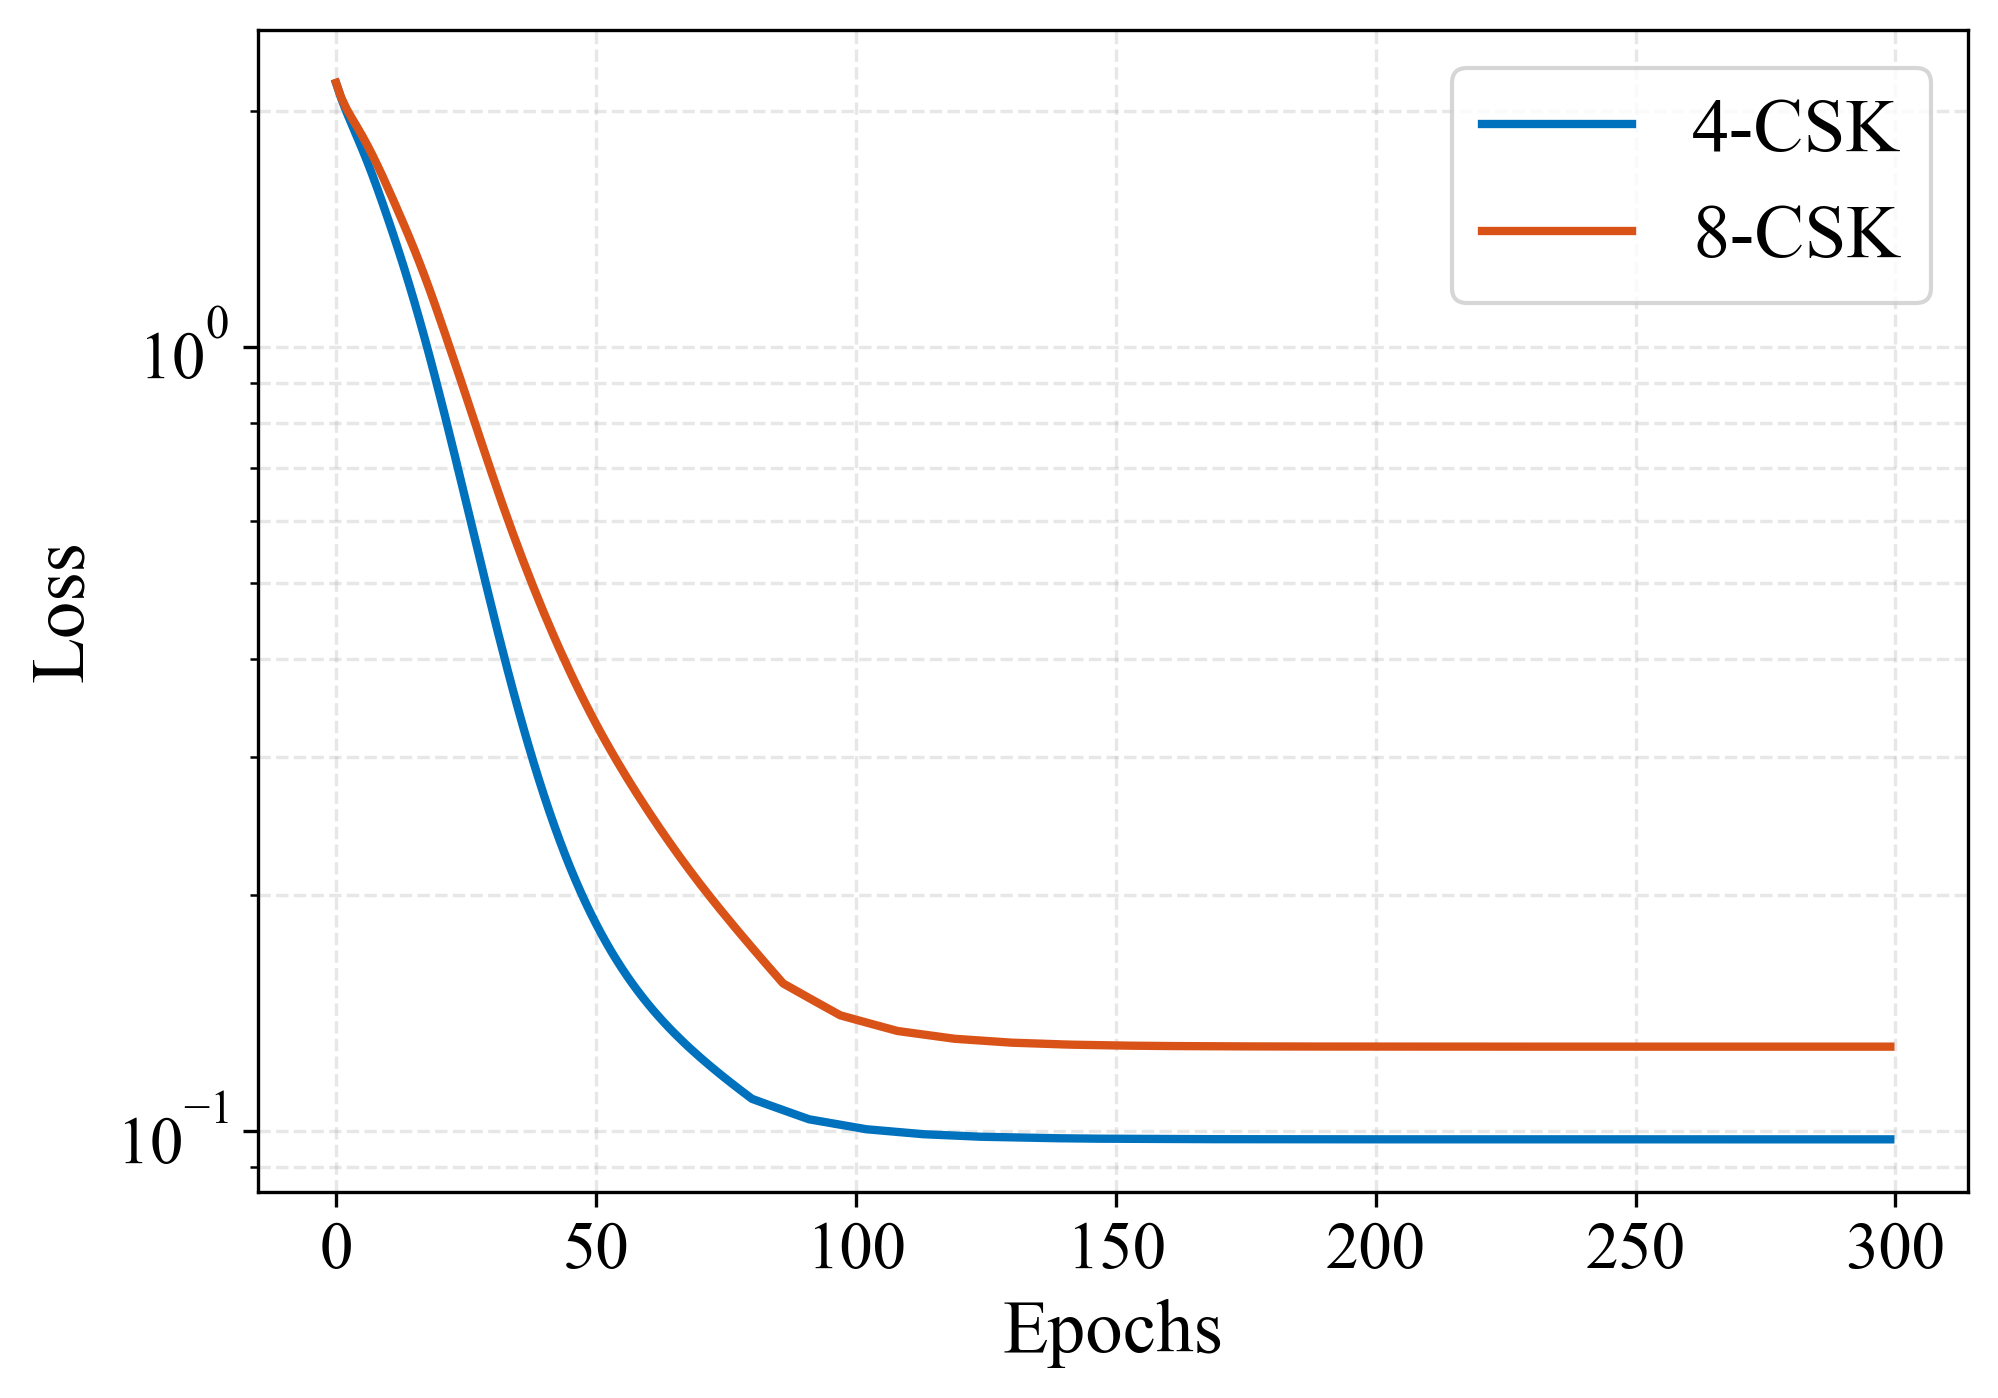

In [9]:
print("\n--- Experiment 4: Convergence Analysis ---")
plt.figure(figsize=(7, 5))
for filename in ['data_4csk.csv', 'data_8csk.csv']:
    if 'best_features_global' in locals() and filename in best_features_global:
        feat_cols = best_features_global[filename]['cols']
        do_norm = best_features_global[filename]['norm']
    else:
        feat_cols = ['Vr', 'Vg', 'Vb']
        do_norm = True
            
    if 'best_params_global' in locals() and filename in best_params_global:
        params = best_params_global[filename]
    else:
        params = {'grid': 5, 'k': 3, 'lr': 0.01, 'weight_decay': 1e-4}
    X_train, X_test, y_train, y_test, num_classes = load_data(filename, feat_cols, normalize=do_norm)
    
    hidden = params.get('hidden_layers', [8])
    layers = [len(feat_cols)] + hidden + [num_classes]
    model = ReLUKAN(layers, grid=params['grid'], k=params['k']).to(device)
    _, history, _ = train_model(model, X_train, y_train, X_test, y_test, epochs=300, lr=params['lr'], weight_decay=params['weight_decay'], verbose=False)
    
    clean_label = '4-CSK' if '4csk' in filename else '8-CSK'
    plt.plot(history['train_loss'], label=clean_label)
    # plt.plot(history['test_ser'], label=f'{filename} Test SER', linestyle='--')

# plt.title('Training Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'plot_convergence.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_DIR, 'plot_convergence.pdf'), format='pdf', dpi=300)

## 7. Transfer Learning & Detailed Evaluation


--- Experiment 5: Transfer Learning (Conceptual) & Final Detailed Metrics ---

--- Final Evaluation for data_4csk.csv using specific params ---


Training: 100%|██████████| 200/200 [00:00<00:00, 472.81it/s, loss=0.133, ser=0.281]


              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.55      0.75      0.63         8
           2       0.78      0.88      0.82         8
           3       0.88      0.88      0.88         8
           4       1.00      0.50      0.67         8
           5       0.70      0.88      0.78         8
           6       0.80      0.50      0.62         8
           7       0.73      1.00      0.84         8

    accuracy                           0.75        64
   macro avg       0.78      0.75      0.74        64
weighted avg       0.78      0.75      0.74        64

Saved CM plot to results\cm_data_4csk.png and results\cm_data_4csk.pdf


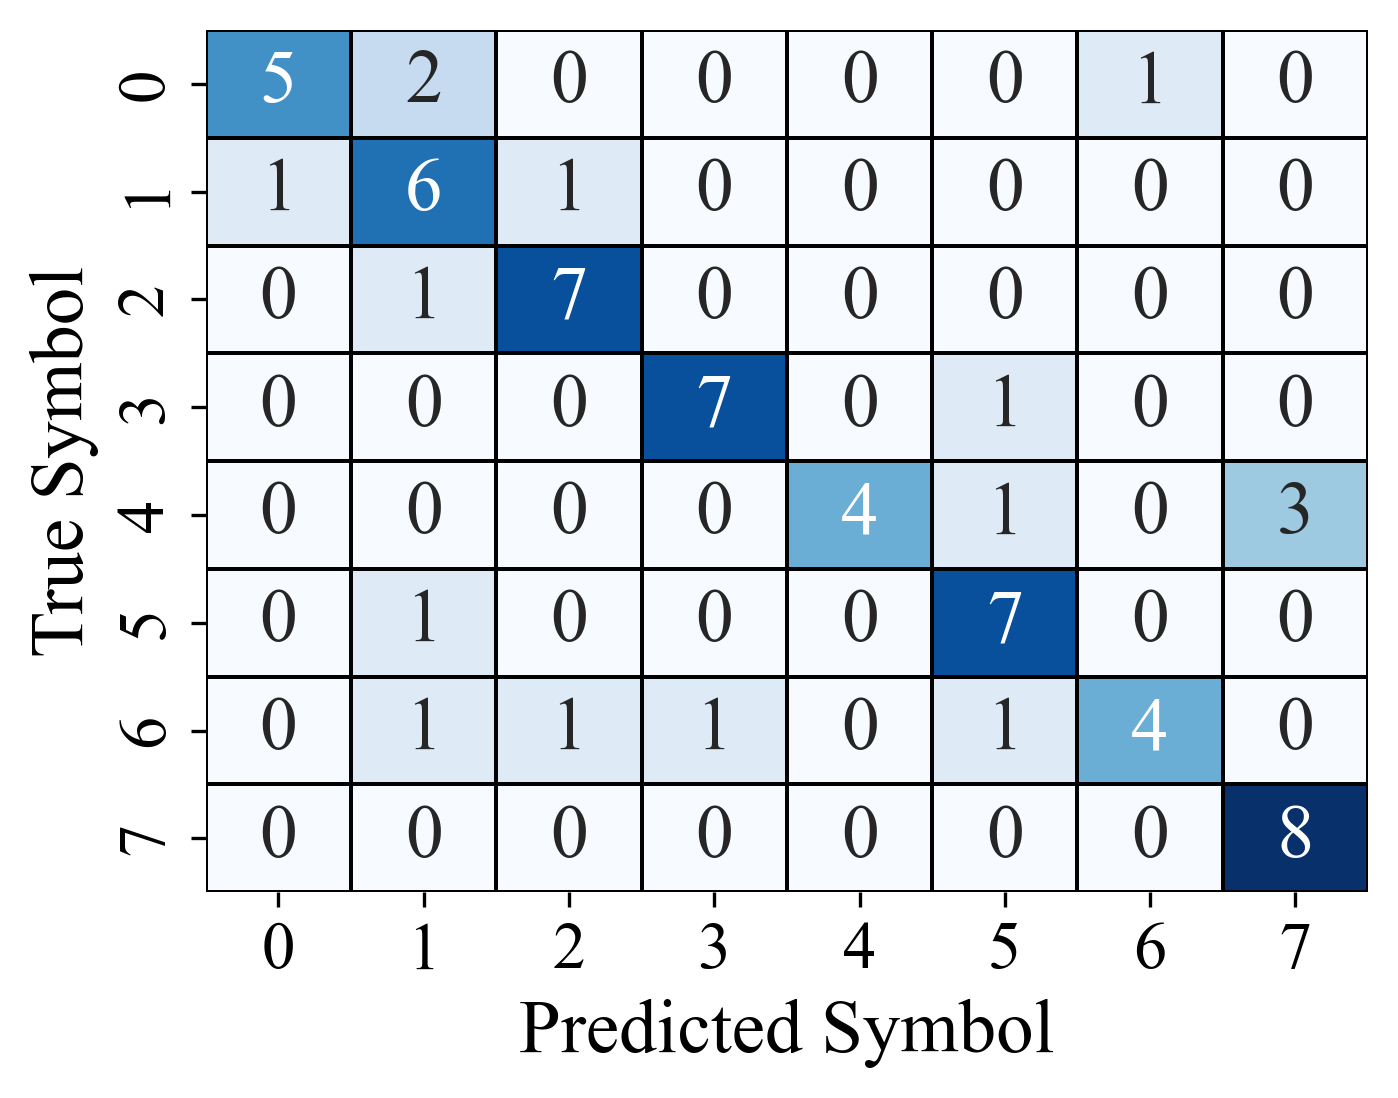


--- Final Evaluation for data_8csk.csv using specific params ---


Training: 100%|██████████| 200/200 [00:00<00:00, 462.96it/s, loss=0.0669, ser=0.453]


              precision    recall  f1-score   support

           0       0.40      0.25      0.31         8
           1       0.56      0.62      0.59         8
           2       1.00      0.88      0.93         8
           3       0.67      0.75      0.71         8
           4       0.86      0.75      0.80         8
           5       0.83      0.62      0.71         8
           6       0.67      0.75      0.71         8
           7       0.50      0.75      0.60         8

    accuracy                           0.67        64
   macro avg       0.68      0.67      0.67        64
weighted avg       0.68      0.67      0.67        64

Saved CM plot to results\cm_data_8csk.png and results\cm_data_8csk.pdf


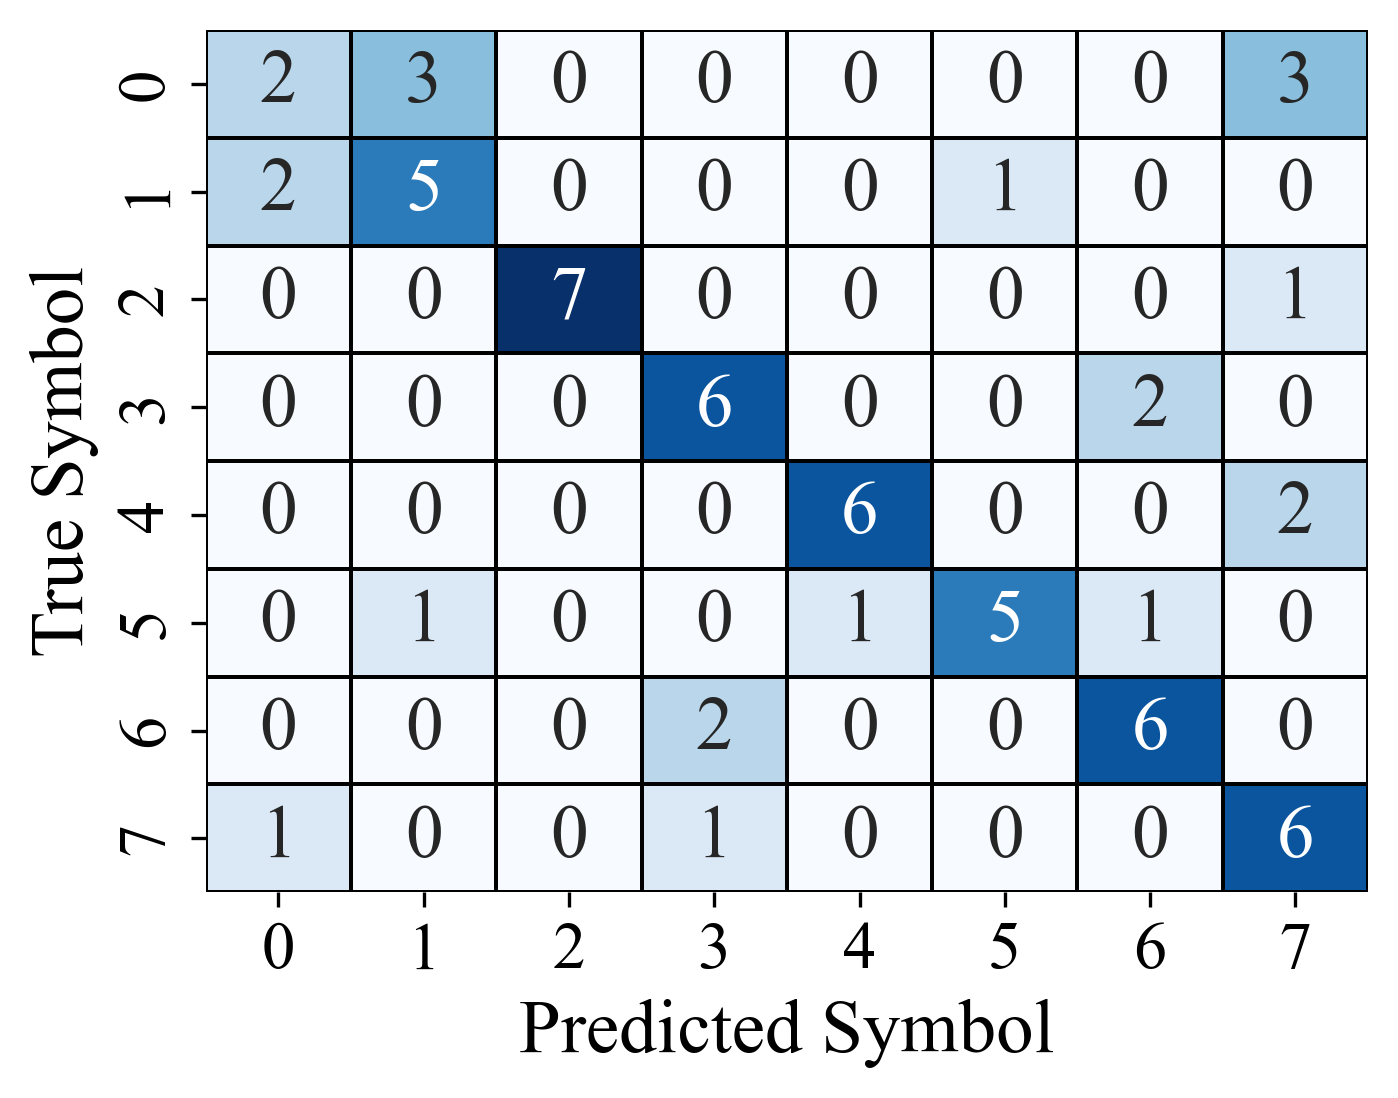

In [10]:
print("\n--- Experiment 5: Transfer Learning (Conceptual) & Final Detailed Metrics ---")
# Note: True transfer learning suggests pre-training on one mod and finetuning on another.
# Here we perform a detailed final run using best parameters found or defaults to generate robust stats.

for filename in ['data_4csk.csv', 'data_8csk.csv']:
    X_train, X_test, y_train, y_test, num_classes = load_data(filename, ['Vr', 'Vg', 'Vb'])
    
    print(f"\n--- Final Evaluation for {filename} using specific params ---")
    
    # Train
    model = ReLUKAN([3, 8, num_classes], grid=5, k=3).to(device)
    _, _, best_model_state = train_model(model, X_train, y_train, X_test, y_test, epochs=200, verbose=True)
    model.load_state_dict(best_model_state)
    
    # Predict
    model.eval()
    with torch.no_grad():
        test_out = model(X_test).squeeze(-1)
        _, preds = torch.max(test_out, 1)
        
    y_true = y_test.cpu().numpy()
    y_pred = preds.cpu().numpy()
    
    # Reports
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred, title=f"CM {filename}", filename=f"cm_{filename.split('.')[0]}.png")
    
    # Save Predictions
    df_pred = pd.DataFrame({'True_Symbol': y_true, 'Predicted_Symbol': y_pred})
    df_pred.to_csv(os.path.join(OUTPUT_DIR, f'predictions_{filename}'), index=False)